<table style="width:100%; border:none;">
  <tr>
    <td style="width:150px; text-align:center; vertical-align:middle;">
      <img src="https://upload.wikimedia.org/wikipedia/en/6/69/Seal_of_Pablo_de_Olavide_University.png" 
           alt="Emblema UPO" 
           style="width:130px; margin:10px;">
    </td>
    <td style="text-align:center; vertical-align:middle;">
      <h2 style="margin-bottom:5px;">Universidad Pablo de Olavide</h2>
      <p><strong>Grado en Ingeniería Informática en Sistemas de Información</strong></p>
      <p><strong>Asignatura: Inteligencia Artificial</strong></p>
      <p><strong>Curso 2025/2026</strong></p>
      <h3 style="margin-top:10px;">TRABAJO #1 – Equipo 08</h3>
      <h4 style="margin-top:5px;">Dataset asignado: Nº 17</h4>
      <p><strong>Integrantes:</strong> María Pérula Gutiérrez &nbsp;·&nbsp; Jonathan Javier Quishpe Maldonado</p>
      <p><strong>Fecha de entrega:</strong> 01/12/2025</p>
    </td>
  </tr>
</table>

<hr style="margin-top:25px; margin-bottom:25px; border: 1px solid #bbb;">
<h2 style="text-align:center;">Regresión Logística - Implementación</h2>

In [231]:
# REGRESIÓN LOGÍSTICA => Coche para estudiante

# Aquí usaremos la regresión logística para separar los coches de nuestro dataset en dos grupos:
#   1 -> coche recomendable para un estudiante universitario
#   0 -> coche que no lo es
#
# Para decidir qué coche es bueno para estudiante nos hemos guiado por caracteristicas de un alumno medio de universidad:
#   - que no sea muy caro,
#   - que gaste poco (economy alta),
#   - que no esté en muy mal estado para no tener muchas averias (condition decente)
#
# Por lo que definiremos una variable binaria (estudiante_ok), y como variables de entrada: price, km, economy, condition y rating. A partir de ahí aplicaremos exactamente
# el esquema de regresión logística de la EPD 3

### 1. Importaciones y lectura del dataset

In [232]:
import pandas as pd
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt

In [233]:
df = pd.read_csv("train.csv")
df = df.rename(columns={"current price": "price"})

In [234]:
#Creamos la variable binaria de estudiante_ok
precio_medio = df["price"].mean()

df["estudiante_ok"] = ((df["economy"] >= 8) & (df["condition"] >= 3) & (df["price"] <= precio_medio)).astype(int)

print("Primeras filas + estudiante_ok:\n")
print(df[["price", "km", "economy", "condition", "rating", "estudiante_ok"]].head())

Primeras filas + estudiante_ok:

      price      km  economy  condition  rating  estudiante_ok
0  351318.0   78945       14          2       1              0
1  285001.5  117220        9          9       5              1
2  215386.0  132538       15          8       2              1
3  244295.5  101065       11          3       4              1
4  531114.5   61559       12          9       3              0


### 2. Variables de entrada X y la clase y | Normalización de características

In [235]:
columnas_X = ["price", "km", "economy", "condition", "rating"]
#X = df[columnas_X].copy()
X_full = df[columnas_X].copy()
y_full = df[["estudiante_ok"]].copy()

#Normalizamos porque nos sale "overflow encountered in exp" en punto "6. Theta, coste y gradiente iniciales"
def featureNormalize(X):
    media = X.mean()
    desv = X.std()
    X_norm = (X - media) / desv
    return X_norm, media, desv

X_norm, media_log, desv_log = featureNormalize(X_full)

unos = np.ones(len(X_norm))
X = X_norm.copy()
X.insert(0, "ones", unos)

print("\nShape de X:", X.shape)
print("Shape de y:", y_full.shape)


Shape de X: (1000, 6)
Shape de y: (1000, 1)


### 3. Función sigmoide

In [236]:
def sigmoid(z):
    # Clipear z para evitar overflow en exp(-z)
    # Cuando z es muy grande (>500), exp(-z) -> 0, entonces sigmoid -> 1
    # Cuando z es muy pequeño (<-500), exp(-z) -> infinito, entonces sigmoid -> 0
    z = np.clip(z, -500, 500)
    denominador = 1 + np.exp(-z)
    g = 1 / denominador
    return g

### 4. Función coste (vectorizada)

In [237]:
def costFunction(theta, X, y):
    m = len(y)
    Xn = X.values # m,n
    yn = y # yn vector de 1D
    z = Xn.dot(theta) # m
    
    h = sigmoid(z) #m
   #Evitamos el log(0) ya que nha encontrado valores 0 o 1 en "6. Theta, coste y gradiente iniciales"
    eps = 1e-8
    h = np.clip(h, eps, 1 - eps)
    
    termino1 = yn * np.log(h)
    termino2 = (1 - yn) * np.log(1 - h)

    J = (-1/m) * np.sum(termino1 + termino2)
    return J

### 5. Función gradiente (vectorizada)

In [238]:
def gradientFunction(theta, X, y_vec):
    m = len(y_vec)
    Xn = X.values
    z = Xn.dot(theta)
    h = sigmoid(z)
    grad = (1/m) * (Xn.T.dot(h - y_vec)) # n
    return grad

### 6. Función predicción

In [239]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

### 7. Validación cruzada - 10 repeticiones (90%/10%)

In [240]:

np.random.seed(0) #mismos splits

alpha = 0.01 #fmin_cg hace su propio paso, este alpha no se usa aqui
maxiter = 400 #nmax iteraciones fmin_cg
n_reps = 10 #10 particiones

accuracy_list = []
TP_list, TN_list, FP_list, FN_list = [], [], [], []

theta_opt_main = None
media_main = None
desv_main = None
cost_history_main = None

for rep in range(n_reps):
    m = len(X_full)
    idx = np.random.permutation(m)
    train_size = int(0.9 * m)

    #90% train, 10% test -> recomendado por la profesora porque no tenemos muchisimos datos
    idx_train = idx[:train_size]
    idx_test  = idx[train_size:]

    X_train_raw = X_full.iloc[idx_train].copy()
    y_train = y_full.iloc[idx_train].copy() #(m_train,1)

    X_test_raw = X_full.iloc[idx_test].copy()
    y_test = y_full.iloc[idx_test].copy()

    #Normalizamos SOLO estadisticas train
    X_train_norm, media, desv = featureNormalize(X_train_raw)
    X_test_norm = (X_test_raw - media) / desv

    #print("DEBUG: tamaño de X_train:", X_train_norm.shape)

    #Añadimos columna de unos
    X_train_norm.insert(0, "ones", 1)
    X_test_norm.insert(0, "ones", 1)

    # heta inicial a ceros (igual que en EPD)
    theta_ini = np.zeros(X_train_norm.shape[1])
    y_train_vec = y_train.to_numpy().flatten()

    #print(theta_ini)

    #Guardar historia de coste solo para esta rep.
    cost_history_rep = []
    def guardar_coste_log(theta_actual):
        c = costFunction(theta_actual, X_train_norm, y_train_vec)
        cost_history_rep.append(c)

    #Entrenamos solo con conjunto de entrenamiento
    theta_opt = op.fmin_cg(
        f=costFunction,
        x0=theta_ini,
        fprime=gradientFunction,
        args=(X_train_norm, y_train_vec),
        maxiter=maxiter,
        callback=guardar_coste_log,
        disp=False # para que no saque todo el log en cada rep.
    )

    #print(theta_opt)

    #Guardamos PRIMERA repetición para dibujar la gráfica y usar como modelo
    if rep == 0:
        theta_opt_main = theta_opt
        media_main = media
        desv_main = desv
        cost_history_main = cost_history_rep

    #Prediccion en el conjunto de test
    y_pred_test = predict(theta_opt, X_test_norm, bool_round=True).astype(int)
    y_test_vec = y_test.to_numpy().flatten()

    #Métricas en test
    accuracy = np.mean(y_pred_test == y_test_vec)
    TP = np.sum((y_test_vec == 1) & (y_pred_test == 1))
    TN = np.sum((y_test_vec == 0) & (y_pred_test == 0))
    FP = np.sum((y_test_vec == 0) & (y_pred_test == 1))
    FN = np.sum((y_test_vec == 1) & (y_pred_test == 0))

    accuracy_list.append(accuracy)
    TP_list.append(TP); TN_list.append(TN); FP_list.append(FP); FN_list.append(FN)

    print(f"Repetición {rep+1} / Accuracy test = {accuracy:.3f}  (TP={TP}, TN={TN}, FP={FP}, FN={FN})")

print("\nMEDIA de las 10 repeticiones (TEST):")
print("Accuracy medio :", np.mean(accuracy_list))
print("TP medio       :", np.mean(TP_list))
print("TN medio       :", np.mean(TN_list))
print("FP medio       :", np.mean(FP_list))
print("FN medio       :", np.mean(FN_list))

#Trabajamos con modelo de la primera repetición (gráficas, ejemplo...)
theta_opt = theta_opt_main
media_log = media_main
desv_log = desv_main
cost_history_log = cost_history_main

Repetición 1 / Accuracy test = 0.850  (TP=28, TN=57, FP=8, FN=7)
Repetición 2 / Accuracy test = 0.890  (TP=27, TN=62, FP=2, FN=9)
Repetición 3 / Accuracy test = 0.870  (TP=27, TN=60, FP=7, FN=6)
Repetición 4 / Accuracy test = 0.880  (TP=32, TN=56, FP=8, FN=4)
Repetición 5 / Accuracy test = 0.840  (TP=37, TN=47, FP=8, FN=8)
Repetición 6 / Accuracy test = 0.860  (TP=30, TN=56, FP=5, FN=9)
Repetición 7 / Accuracy test = 0.850  (TP=35, TN=50, FP=6, FN=9)
Repetición 8 / Accuracy test = 0.850  (TP=28, TN=57, FP=6, FN=9)
Repetición 9 / Accuracy test = 0.870  (TP=33, TN=54, FP=7, FN=6)
Repetición 10 / Accuracy test = 0.850  (TP=28, TN=57, FP=4, FN=11)

MEDIA de las 10 repeticiones (TEST):
Accuracy medio : 0.8610000000000001
TP medio       : 30.5
TN medio       : 55.6
FP medio       : 6.1
FN medio       : 7.8


### 8. Theta, coste y gradiente iniciales

In [241]:
n_param = X.shape[1]
theta_ini = np.zeros(n_param) #vector 1D
y_vec = y_full.to_numpy().flatten() #m

print("\nCoste inicial con theta (0): ", costFunction(theta_ini, X, y_vec))
print("Gradiente inicial: \n", gradientFunction(theta_ini, X, y_vec))

#Para la gráfica
cost_history_log = []
def guardar_coste_log(theta):
    c = costFunction(theta, X, y_vec)
    cost_history_log.append(c)

# Optimizacion fmin_cg
theta_opt = op.fmin_cg(
    f = costFunction,
    x0 = theta_ini,
    fprime = gradientFunction,
    args = (X, y_vec),
    maxiter = 400,
    callback = guardar_coste_log
)

print("\nTheta optimo:")
print(theta_opt)


Coste inicial con theta (0):  0.6931471805599454
Gradiente inicial: 
 [ 0.092       0.3397436  -0.33782546 -0.01927776 -0.09611219  0.0307273 ]
Optimization terminated successfully.
         Current function value: 0.289499
         Iterations: 20
         Function evaluations: 63
         Gradient evaluations: 63

Theta optimo:
[-1.04196569 -3.10130639  0.22287656  0.03599764  1.41479513 -0.19275264]
Optimization terminated successfully.
         Current function value: 0.289499
         Iterations: 20
         Function evaluations: 63
         Gradient evaluations: 63

Theta optimo:
[-1.04196569 -3.10130639  0.22287656  0.03599764  1.41479513 -0.19275264]


### 9. Gráfica de convergencia

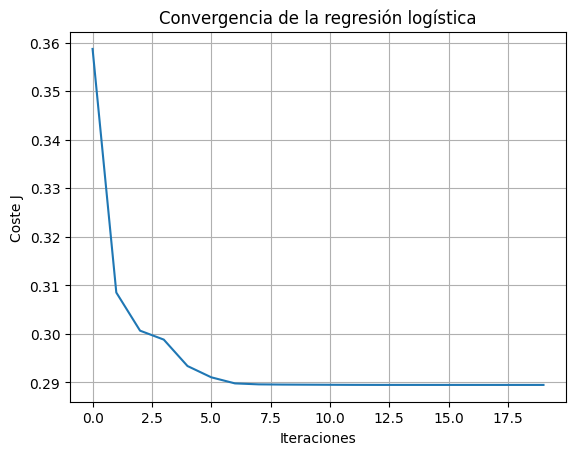

In [242]:
plt.plot(cost_history_log)
plt.xlabel("Iteraciones")
plt.ylabel("Coste J")
plt.title("Convergencia de la regresión logística")
plt.grid(True)
plt.show()

### 10. Predicciones

In [243]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

# Necesitamos: Coche barato, con pocos km, que tenga buena economía con una condición decente y un rating medio aceptable
# Valores seleccionados [price, km, economy, condition, rating]
ejemplo_coche_raw = [200000, 50000, 9, 4, 4]

# Normalizamos usando media/desviación qdel entrenamiento
ejemplo_norm = (np.array(ejemplo_coche_raw) - media_log.values) / desv_log.values

# Añadimos el 1 inicial
fila_ejemplo = np.insert(ejemplo_norm, 0, 1)  # [1, price, km, economy, condition, rating]

df_ejemplo = pd.DataFrame([fila_ejemplo], columns=X.columns)

ej_prob = predict(theta_opt, df_ejemplo, bool_round=False)
ej_clase = predict(theta_opt, df_ejemplo, bool_round=True)

print("\nEjemplo de coche para estudiante:")
print("Características originales (sin normalizar):", ejemplo_coche_raw)
print("Probabilidad de ser 'estudiante_ok':", float(ej_prob[0]))
print("Predicción (0/1):", int(ej_clase[0]))


Ejemplo de coche para estudiante:
Características originales (sin normalizar): [200000, 50000, 9, 4, 4]
Probabilidad de ser 'estudiante_ok': 0.5459667519044216
Predicción (0/1): 1


### 11. Evaluación usando TODO el dataset

In [244]:
X_full_norm = (X_full - media_log) / desv_log
X_full_norm.insert(0, "ones", 1)

y_pred_full = predict(theta_opt, X_full_norm, bool_round=True).astype(int)
y_real_full = y_full.to_numpy().flatten()

accuracy_full = np.mean(y_pred_full == y_real_full)
print("\nAccuracy del modelo sobre TODO el dataset:", accuracy_full)

TP = np.sum((y_real_full == 1) & (y_pred_full == 1))
TN = np.sum((y_real_full == 0) & (y_pred_full == 0))
FP = np.sum((y_real_full == 0) & (y_pred_full == 1))
FN = np.sum((y_real_full == 1) & (y_pred_full == 0))

print("\nMatriz de confusión (todo el dataset):")
print("TP (1 bien predicho):", TP)
print("TN (0 bien predicho):", TN)
print("FP (0 mal como 1)   :", FP)
print("FN (1 mal como 0)   :", FN)


Accuracy del modelo sobre TODO el dataset: 0.856

Matriz de confusión (todo el dataset):
TP (1 bien predicho): 329
TN (0 bien predicho): 527
FP (0 mal como 1)   : 65
FN (1 mal como 0)   : 79


In [245]:
# Conclusiones: El modelo de regresión logística para estudiante_ok da un accuracy de 0.85 (85%), acierta aproximadamente 8 de cada 10 coches, que está bastante bien
# para las 5 variables que usamos.
#
# La matriz de confusión muestra que acierta bastantes ok y no ok, aunque hay algunos coches buenos que descarta y otros que sobrevalora, algo típico en este modelo sencillo.
#
# Viendo las gráficas de price vs economy, tanto los datos reales como las predicciones siguen la idea que teníamos: los coches más baratos y con mejor
# economía son los que salen como buenos para un estudiante.

### 12. Gráfica price vs economy (real vs predicho)

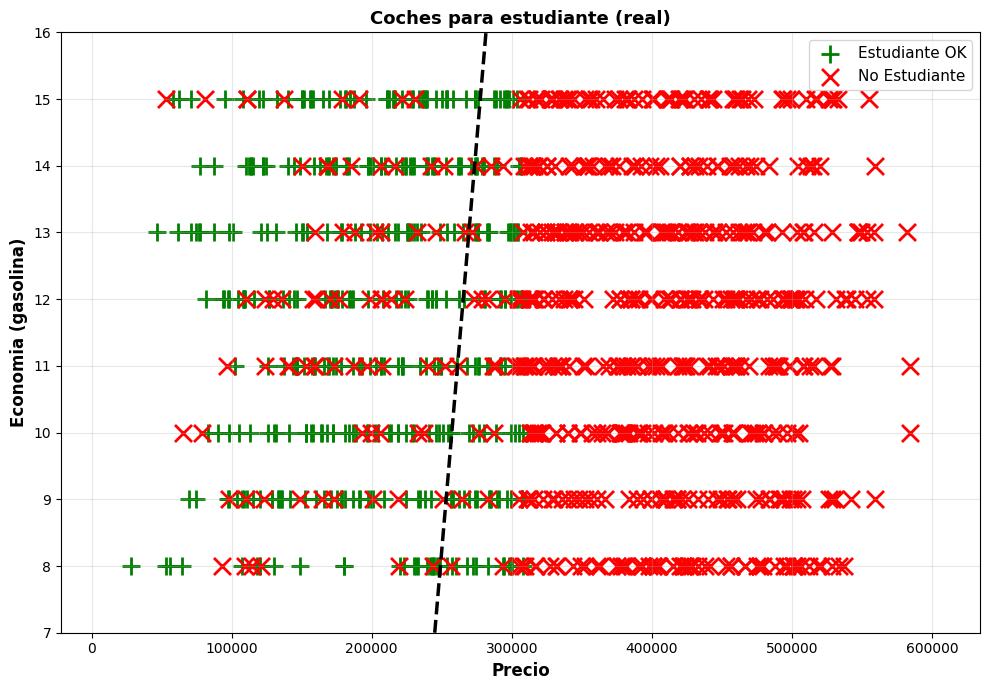

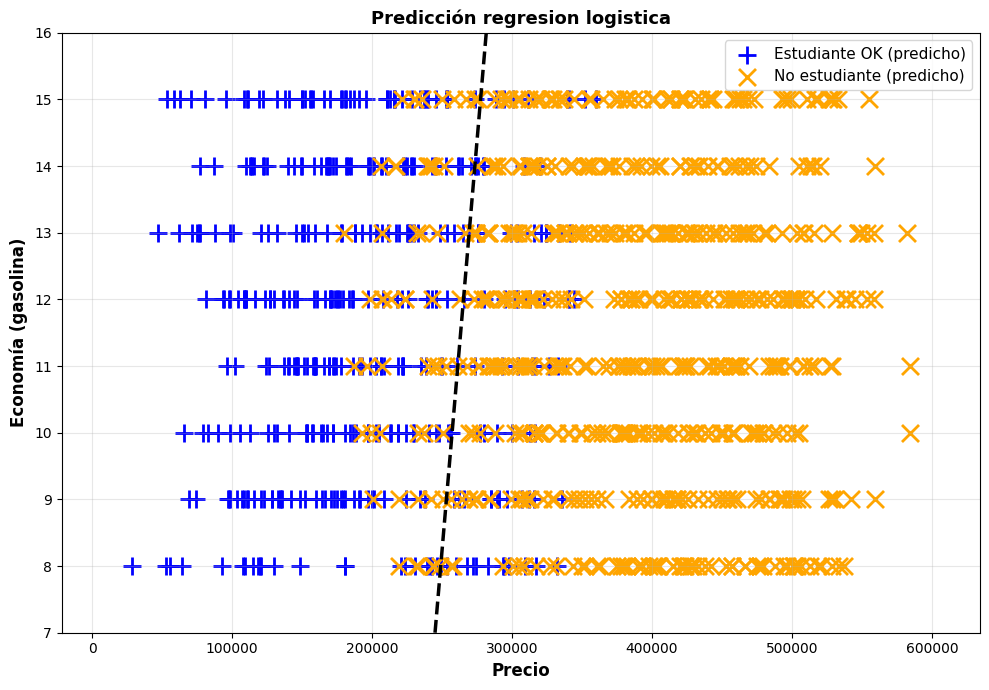

In [246]:
# En nuestro caso estamos usando 5 variables para saber si un coche es apropiado para un estudiante medio, pero como no se puede dibujar en 5D,
# hemos pensado en observar estas gráficas con dos variables bastante significativas en este caso: price y economy.
# Un estudiante principalmente (según nuestro criterio), se fija en estas dos opciones.

import matplotlib.pyplot as plt

# Dibujamos los puntos reales segun la clase
def plot_estudiante_real(df):
    
    df_ok = df[df["estudiante_ok"] == 1]
    df_no = df[df["estudiante_ok"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df["price"].min() - 50000, df["price"].max() + 50000
    min_econ, max_econ = df["economy"].min() - 1, df["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="g", marker="+", s=150, label="Estudiante OK", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="r", marker="x", s=150, label="No Estudiante", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economia (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Coches para estudiante (real)", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Dibujamos lo que predice nuestra regresion logistica
def plot_estudiante_pred(df_clasif):
    
    df_ok = df_clasif[df_clasif["pred_clase"] == 1]
    df_no = df_clasif[df_clasif["pred_clase"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df_clasif["price"].min() - 50000, df_clasif["price"].max() + 50000
    min_econ, max_econ = df_clasif["economy"].min() - 1, df_clasif["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(10, 7))

    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="b", marker="+", s=150, label="Estudiante OK (predicho)", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="orange", marker="x", s=150, label="No estudiante (predicho)", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economía (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Predicción regresion logistica", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Clasificamos el dataset con el modelo aprendido
pred_clase = predict(theta_opt, X, bool_round=True)

df_clasificado = df.copy()
df_clasificado["pred_clase"] = pred_clase

# Gráfica del real
plot_estudiante_real(df)

# Gráfica del predicho
df_clasificado_plot = df_clasificado.copy()
df_clasificado_plot["price"] = df["price"]
df_clasificado_plot["economy"] = df["economy"]

plot_estudiante_pred(df_clasificado_plot)

# Conclusión: En la gráfica real los coches marcados como estudiante_ok están sobre todo en la zona de precio bajo y economía baja.
# En la grafica de predicción se ve un patrón parecido: el modelo tiende a marcar como buenos para estudiante los coches más baratos, aunque hay algunos puntos que se escapan en la economía (gasto medio gasolina)
# Para ser un modelo sencillo con 5 variables, la tasa de acierto es razonable (85%).

### 13 Análisis de la Frontera de Decisión

La frontera de decisión es la línea (o superficie en dimensiones superiores) que separa las regiones del espacio de características donde el modelo predice una clase u otra. En regresión logística, esta frontera se define matemáticamente como:

$$h_\theta(x) = 0.5 \quad \Rightarrow \quad \theta^T x = 0$$

**Objetivos de este análisis:**
1. Visualizar la frontera de decisión para el mejor par de características
2. Analizar cómo cambia la frontera con diferentes learning rates(alphas)
3. Estudiar el impacto para diferentes inicializaciones de parámetros en la frontera
4. Discutir la linealidad de la separación y la sensibilidad a las características

### 13.1 Frontera de Decisión de los Mejores Pares de Características

In [247]:
from itertools import combinations

# Seleccionamos 6 variables para hacer análisis por pares
variables_analisis = ["price", "km", "economy", "condition", "rating"]

# Generamos todas las combinaciones de 2 variables
pares_variables = list(combinations(variables_analisis, 2))
print(f"Pares de variables a analizar: {len(pares_variables)}")
print("\nCombinaciones generadas:")
for i, par in enumerate(pares_variables, 1):
    print(f"  {i}. {par[0]} vs {par[1]}")

# Diccionario para guardar resultados
resultados_modelos = {}


Pares de variables a analizar: 10

Combinaciones generadas:
  1. price vs km
  2. price vs economy
  3. price vs condition
  4. price vs rating
  5. km vs economy
  6. km vs condition
  7. km vs rating
  8. economy vs condition
  9. economy vs rating
  10. condition vs rating


In [248]:
def entrenar_modelo_par(X_par, y, nombre_par):
    """Entrena un modelo de regresión logística con un par de variables"""
    
    # Normalizamos
    X_norm, media, desv = featureNormalize(X_par)
    
    # Añadimos columna de unos
    unos = np.ones(len(X_norm))
    X_modelo = X_norm.copy()
    X_modelo.insert(0, "ones", unos)
    
    # Inicializamos theta
    n_param = X_modelo.shape[1]
    theta_ini = np.zeros(n_param)
    y_vec = y.to_numpy().flatten()
    
    # Optimización
    theta_opt = op.fmin_cg(
        f=costFunction,
        x0=theta_ini,
        fprime=gradientFunction,
        args=(X_modelo, y_vec),
        maxiter=400,
        disp=False
    )
    
    # Predicciones
    y_pred = predict(theta_opt, X_modelo, bool_round=True)
    
    # Evaluación
    accuracy = np.mean(y_pred == y_vec)
    
    # Matriz de confusión
    TP = np.sum((y_vec == 1) & (y_pred == 1))
    TN = np.sum((y_vec == 0) & (y_pred == 0))
    FP = np.sum((y_vec == 0) & (y_pred == 1))
    FN = np.sum((y_vec == 1) & (y_pred == 0))
    
    # Calculamos métricas adicionales
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'theta': theta_opt,
        'X_modelo': X_modelo,
        'accuracy': accuracy,
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'media': media,
        'desv': desv
    }


In [249]:
# Entrenamos modelos para cada par
for par in pares_variables:
    var1, var2 = par
    
    X_par = df[[var1, var2]].copy()
    modelo = entrenar_modelo_par(X_par, y_full, par)
    
    resultados_modelos[par] = modelo


In [250]:
print("\n" + "="*80)
print("TABLA RESUMEN - RENDIMIENTO DE MODELOS")
print("="*80)

resultados_df = []
for par, modelo in resultados_modelos.items():
    resultados_df.append({
        'Variables': f"{par[0]} vs {par[1]}",
        'Accuracy': modelo['accuracy'],
        'Precisión': modelo['precision'],
        'Recall': modelo['recall'],
        'F1-Score': modelo['f1']
    })

tabla_resumen = pd.DataFrame(resultados_df)
print(tabla_resumen.to_string(index=False))

# Identificar mejor modelo
mejor_par = max(resultados_modelos.items(), key=lambda x: x[1]['accuracy'])
print(f"\nMEJOR PAR DE VARIABLES (por Accuracy): {mejor_par[0]}")
print(f"  Accuracy: {mejor_par[1]['accuracy']:.4f}")



TABLA RESUMEN - RENDIMIENTO DE MODELOS
           Variables  Accuracy  Precisión   Recall  F1-Score
         price vs km     0.846   0.812808 0.808824  0.810811
    price vs economy     0.837   0.810127 0.784314  0.797011
  price vs condition     0.854   0.824257 0.816176  0.820197
     price vs rating     0.845   0.812346 0.806373  0.809348
       km vs economy     0.844   0.804348 0.816176  0.810219
     km vs condition     0.847   0.813268 0.811275  0.812270
        km vs rating     0.840   0.799517 0.811275  0.805353
economy vs condition     0.549   0.407725 0.232843  0.296412
   economy vs rating     0.592   0.000000 0.000000  0.000000
 condition vs rating     0.548   0.409091 0.242647  0.304615

MEJOR PAR DE VARIABLES (por Accuracy): ('price', 'condition')
  Accuracy: 0.8540


In [251]:
def plot_frontera_decision(par, modelo, X_par_original):
    """
    Función auxiliar para visualizar la frontera de decisión de un modelo entrenado con 2 variables.
    """
    var1, var2 = par
    theta = modelo['theta']
    media = modelo['media']
    desv = modelo['desv']
    
    # Crear malla de puntos para el fondo (contour plot)
    x1_min, x1_max = X_par_original[var1].min(), X_par_original[var1].max()
    x2_min, x2_max = X_par_original[var2].min(), X_par_original[var2].max()
    
    # Añadir un poco de margen
    x1_range = x1_max - x1_min
    x2_range = x2_max - x2_min
    x1_min -= 0.1 * x1_range
    x1_max += 0.1 * x1_range
    x2_min -= 0.1 * x2_range
    x2_max += 0.1 * x2_range
    
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                           np.linspace(x2_min, x2_max, 100))
    
    # Aplanar y preparar para predecir
    grid_flat = np.c_[xx1.ravel(), xx2.ravel()]
    
    # Normalizar los puntos de la malla usando las estadísticas del entrenamiento
    grid_norm = np.zeros_like(grid_flat)
    grid_norm[:, 0] = (grid_flat[:, 0] - media[var1]) / desv[var1]
    grid_norm[:, 1] = (grid_flat[:, 1] - media[var2]) / desv[var2]
    
    # Añadir columna de unos (bias)
    grid_model = np.c_[np.ones(grid_norm.shape[0]), grid_norm]
    
    # Calcular predicciones (probabilidades)
    z = grid_model.dot(theta)
    h = sigmoid(z)
    h = h.reshape(xx1.shape)
    
    # Graficar
    plt.figure(figsize=(8, 6))
    
    # Dibujar frontera (nivel 0.5)
    plt.contour(xx1, xx2, h, levels=[0.5], colors='blue', linewidths=2)
    
    # Dibujar puntos de datos originales
    # Usamos df global para obtener las etiquetas reales
    pos = df['estudiante_ok'] == 1
    neg = df['estudiante_ok'] == 0
    
    plt.scatter(df.loc[pos, var1], df.loc[pos, var2], c='g', marker='+', label='Estudiante OK')
    plt.scatter(df.loc[neg, var1], df.loc[neg, var2], c='r', marker='x', label='No Estudiante')
    
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f"Frontera de Decisión: {var1} vs {var2}\nAccuracy: {modelo['accuracy']:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


VISUALIZACIÓN DE LAS 5 MEJORES FRONTERAS DE DECISIÓN (Por Accuracy)

[1/5] Graficando: price vs condition (Accuracy: 0.8540)


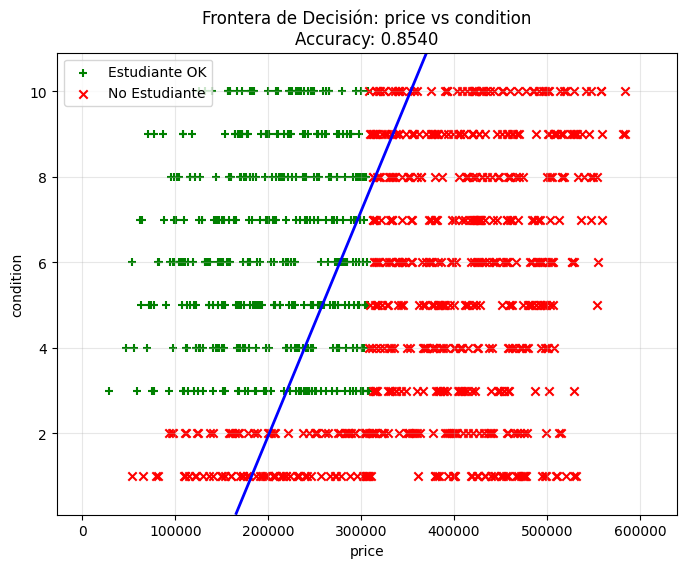


[2/5] Graficando: km vs condition (Accuracy: 0.8470)


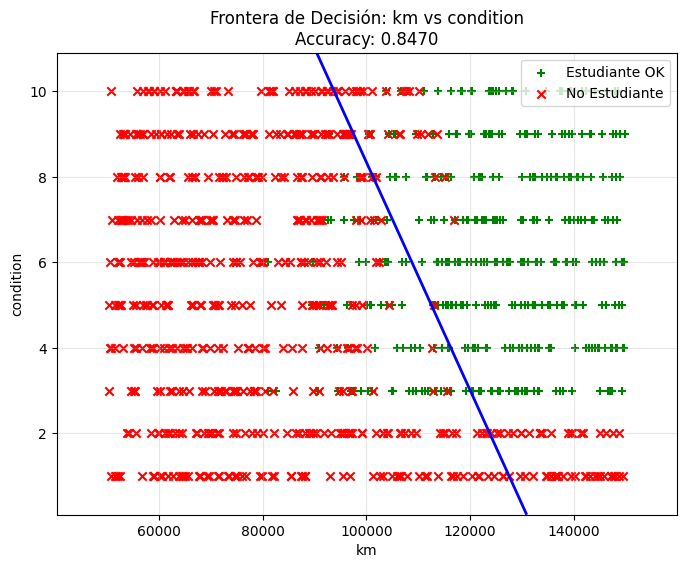


[3/5] Graficando: price vs km (Accuracy: 0.8460)


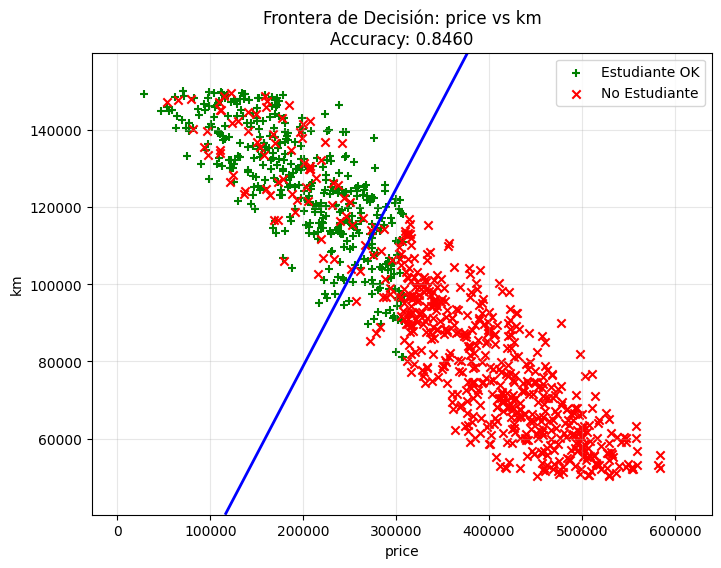


[4/5] Graficando: price vs rating (Accuracy: 0.8450)


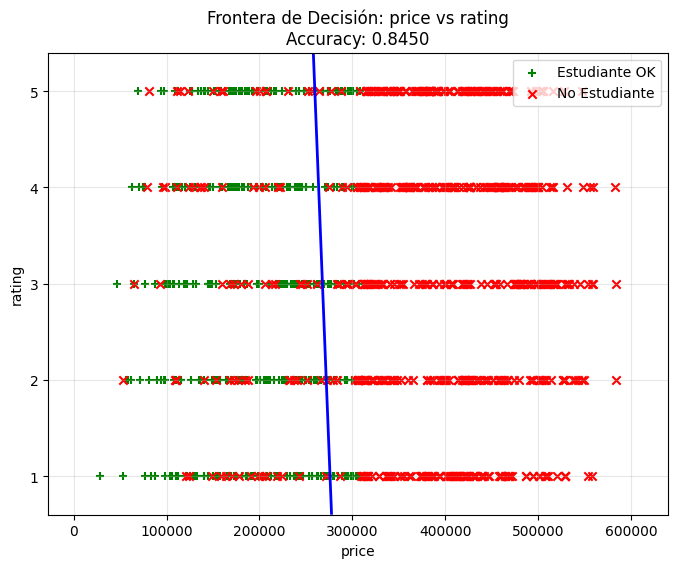


[5/5] Graficando: km vs economy (Accuracy: 0.8440)


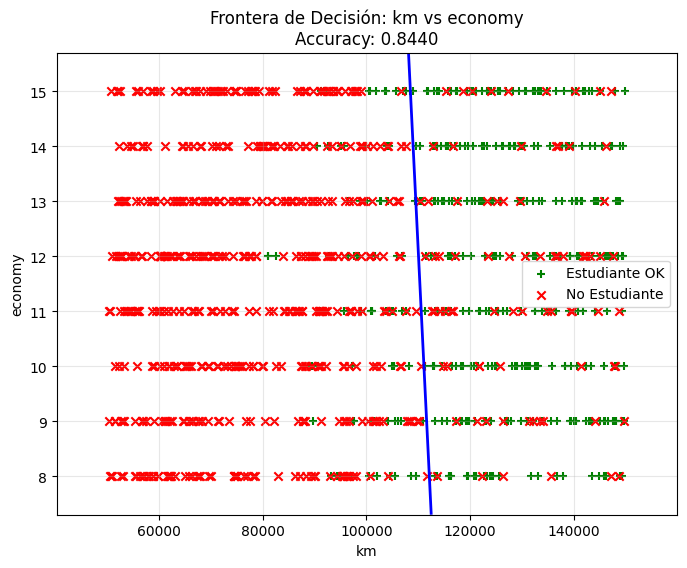

In [252]:
# Visualizar fronteras para los 5 pares con mejor accuracy
print("\n" + "="*80)
print("VISUALIZACIÓN DE LAS 5 MEJORES FRONTERAS DE DECISIÓN (Por Accuracy)")
print("="*80)

# Ordenar modelos por accuracy (descendente)
modelos_ordenados = sorted(resultados_modelos.items(), 
                           key=lambda x: x[1]['accuracy'], 
                           reverse=True)

# Tomar solo los 5 mejores
mejores_5 = modelos_ordenados[:5]

for idx, (par, modelo) in enumerate(mejores_5, 1):
    X_par_original = df[[par[0], par[1]]].copy()
    print(f"\n[{idx}/5] Graficando: {par[0]} vs {par[1]} (Accuracy: {modelo['accuracy']:.4f})")
    plot_frontera_decision(par, modelo, X_par_original)

### 13.1 Extracción del Mejor Modelo entrenado con los Mejores Pares de Características

A continuación, se extrae el mejor modelo (el que tiene mayor accuracy) de los 5 analizados para realizar un análisis detallado del mismo.

In [253]:
# Extraer el mejor modelo
mejor_par, mejor_modelo = mejores_5[0]
var1_best, var2_best = mejor_par

print("\n" + "="*80)
print("MEJOR MODELO SELECCIONADO PARA ANÁLISIS DETALLADO")
print("="*80)
print(f"\nPar de variables: {var1_best} vs {var2_best}")
print(f"Accuracy: {mejor_modelo['accuracy']:.6f}")
print(f"\nParámetros del modelo:")
print(f"  θ_0 (bias):    {mejor_modelo['theta'][0]:+.6f}")
print(f"  θ_1 ({var1_best}): {mejor_modelo['theta'][1]:+.6f}")
print(f"  θ_2 ({var2_best}): {mejor_modelo['theta'][2]:+.6f}")

# Almacenar variables para usar en análisis posteriores
mejor_theta = mejor_modelo['theta']
mejor_media = mejor_modelo['media']
mejor_desv = mejor_modelo['desv']
mejor_accuracy = mejor_modelo['accuracy']

# Preparar datos para el mejor modelo
X_mejor_raw = df[[var1_best, var2_best]].copy()
X_mejor_norm = (X_mejor_raw - mejor_media) / mejor_desv
X_mejor = X_mejor_norm.copy()
X_mejor.insert(0, "ones", np.ones(len(X_mejor_norm)))

# Predicciones con el mejor modelo
y_pred_mejor = predict(mejor_theta, X_mejor, bool_round=True)
y_vec_mejor = y_full.to_numpy().flatten()

# Matriz de confusión del mejor modelo
TP_mejor = np.sum((y_vec_mejor == 1) & (y_pred_mejor == 1))
TN_mejor = np.sum((y_vec_mejor == 0) & (y_pred_mejor == 0))
FP_mejor = np.sum((y_vec_mejor == 0) & (y_pred_mejor == 1))
FN_mejor = np.sum((y_vec_mejor == 1) & (y_pred_mejor == 0))

print(f"\nMétricas de rendimiento:")
print(f"  TP: {TP_mejor}, TN: {TN_mejor}, FP: {FP_mejor}, FN: {FN_mejor}")
print(f"  Precision: {TP_mejor/(TP_mejor+FP_mejor):.6f}")
print(f"  Recall: {TP_mejor/(TP_mejor+FN_mejor):.6f}")
print("="*80)


MEJOR MODELO SELECCIONADO PARA ANÁLISIS DETALLADO

Par de variables: price vs condition
Accuracy: 0.854000

Parámetros del modelo:
  θ_0 (bias):    -1.026619
  θ_1 (price): -3.314038
  θ_2 (condition): +1.412498

Métricas de rendimiento:
  TP: 333, TN: 521, FP: 71, FN: 75
  Precision: 0.824257
  Recall: 0.816176


1. Visualizando frontera del mejor modelo...


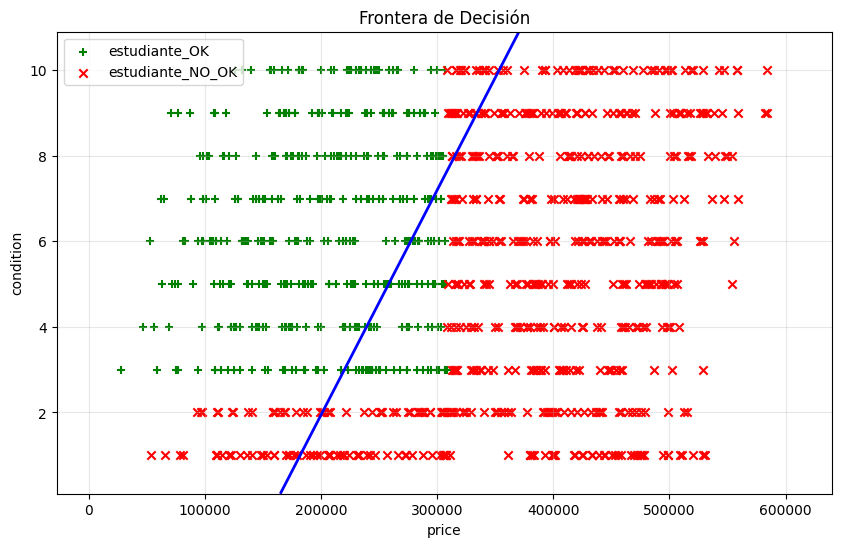

In [254]:
# 1. Visualizar la frontera de decisión para el mejor par de variables
def visualizar_frontera(theta, X_raw, y, var1, var2, media, desv, titulo="Frontera de Decisión"):
    # Crear malla
    x1_min, x1_max = X_raw[var1].min(), X_raw[var1].max()
    x2_min, x2_max = X_raw[var2].min(), X_raw[var2].max()
    
    # Margen
    x1_range = x1_max - x1_min
    x2_range = x2_max - x2_min
    x1_min -= 0.1 * x1_range
    x1_max += 0.1 * x1_range
    x2_min -= 0.1 * x2_range
    x2_max += 0.1 * x2_range
    
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                           np.linspace(x2_min, x2_max, 100))
    
    # Aplanar y normalizar
    grid_flat = np.c_[xx1.ravel(), xx2.ravel()]
    
    # Normalizar usando media y desv del modelo entrenado
    # Asumimos que media y desv son Series con índices correspondientes a las variables
    grid_norm = np.zeros_like(grid_flat)
    grid_norm[:, 0] = (grid_flat[:, 0] - media[var1]) / desv[var1]
    grid_norm[:, 1] = (grid_flat[:, 1] - media[var2]) / desv[var2]
    
    # Añadir bias
    grid_model = np.c_[np.ones(grid_norm.shape[0]), grid_norm]
    
    # Predecir
    z = grid_model.dot(theta)
    h = sigmoid(z)
    h = h.reshape(xx1.shape)
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    # Puntos
    pos = y.flatten() == 1
    neg = y.flatten() == 0
    
    plt.scatter(X_raw.loc[pos, var1], X_raw.loc[pos, var2], c='g', marker='+', label='estudiante_OK')
    plt.scatter(X_raw.loc[neg, var1], X_raw.loc[neg, var2], c='r', marker='x', label='estudiante_NO_OK')
    
    # Frontera
    plt.contour(xx1, xx2, h, levels=[0.5], colors='blue', linewidths=2)
    
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(titulo)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("1. Visualizando frontera del mejor modelo...")
visualizar_frontera(mejor_theta, X_mejor_raw, y_full.to_numpy(), var1_best, var2_best, mejor_media, mejor_desv)


2. Análisis de Learning Rates (Descenso de Gradiente)...


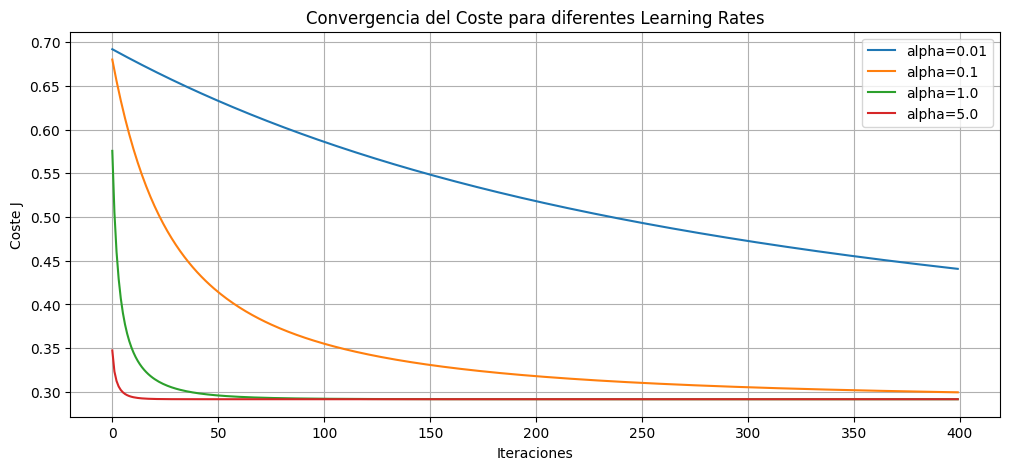


3. Impacto de la inicialización de parámetros...
Inicialización       | Coste Final  | Accuracy  
--------------------------------------------------
Ceros                | 0.291549   | 0.8540
Aleatorio Pequeño    | 0.291549   | 0.8540
Aleatorio Grande     | 0.291549   | 0.8540
Aleatorio Pequeño    | 0.291549   | 0.8540
Aleatorio Grande     | 0.291549   | 0.8540


In [255]:
# 2. Analizar cómo cambia la frontera con diferentes learning rates (usando Gradient Descent simple)
print("\n2. Análisis de Learning Rates (Descenso de Gradiente)...")

def gradient_descent_simple(X, y, theta, alpha, num_iters):
    m = len(y)
    J_history = []
    theta_hist = theta.copy()
    
    for i in range(num_iters):
        h = sigmoid(X.dot(theta_hist))
        grad = (1/m) * (X.T.dot(h - y))
        theta_hist = theta_hist - alpha * grad
        J_history.append(costFunction(theta_hist, pd.DataFrame(X), y))
        
    return theta_hist, J_history

alphas = [0.01, 0.1, 1.0, 5.0]
plt.figure(figsize=(12, 5))

# Preparamos datos (ya normalizados y con bias del mejor modelo)
X_gd = X_mejor.values
y_gd = y_full.to_numpy().flatten()
theta_init_gd = np.zeros(X_gd.shape[1])

for alpha in alphas:
    theta_final, J_hist = gradient_descent_simple(X_gd, y_gd, theta_init_gd, alpha, 400)
    plt.plot(J_hist, label=f'alpha={alpha}')
    
plt.xlabel('Iteraciones')
plt.ylabel('Coste J')
plt.title('Convergencia del Coste para diferentes Learning Rates')
plt.legend()
plt.grid(True)
plt.show()


# 3. Impacto de la inicialización de parámetros
print("\n3. Impacto de la inicialización de parámetros...")
initializations = {
    'Ceros': np.zeros(X_mejor.shape[1]),
    'Aleatorio Pequeño': np.random.randn(X_mejor.shape[1]) * 0.01,
    'Aleatorio Grande': np.random.randn(X_mejor.shape[1]) * 10
}

print(f"{'Inicialización':<20} | {'Coste Final':<12} | {'Accuracy':<10}")
print("-" * 50)

for name, theta_ini in initializations.items():
    theta_opt_init = op.fmin_cg(
        f=costFunction,
        x0=theta_ini,
        fprime=gradientFunction,
        args=(X_mejor, y_gd),
        maxiter=400,
        disp=False
    )
    cost_final = costFunction(theta_opt_init, X_mejor, y_gd)
    pred = predict(theta_opt_init, X_mejor, bool_round=True)
    acc = np.mean(pred == y_gd)
    print(f"{name:<20} | {cost_final:.6f}   | {acc:.4f}")


4. Análisis de Sensibilidad (Importancia de Características)...


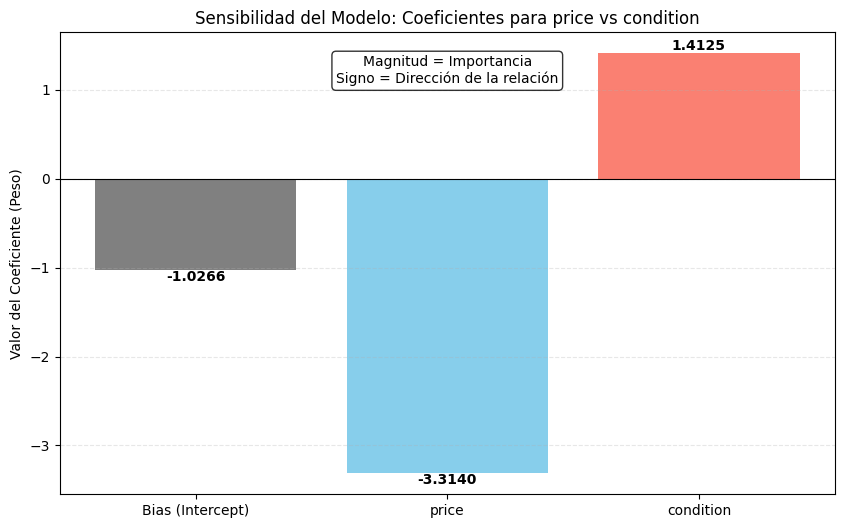

Interpretación de la Sensibilidad:
- price: Coeficiente = -3.3140
- condition: Coeficiente = 1.4125
------------------------------------------------------------
1. La MAGNITUD (valor absoluto) indica la fuerza del impacto de la variable.
2. El SIGNO indica la dirección:
   (+) Positivo: A mayor valor de la variable, mayor probabilidad de ser 'Estudiante OK'.
   (-) Negativo: A mayor valor de la variable, menor probabilidad de ser 'Estudiante OK'.


In [256]:
# 4. Análisis de Sensibilidad a las Características (Pesos del Modelo)
print("\n4. Análisis de Sensibilidad (Importancia de Características)...")

# Nombres de las características (Bias + las 2 variables del mejor modelo)
features = ['Bias (Intercept)', var1_best, var2_best]
weights = mejor_theta

plt.figure(figsize=(10, 6))
# Crear gráfico de barras
bars = plt.bar(features, weights, color=['gray', 'skyblue', 'salmon'])

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom' if height > 0 else 'top',
             fontweight='bold')

plt.title(f'Sensibilidad del Modelo: Coeficientes para {var1_best} vs {var2_best}')
plt.ylabel('Valor del Coeficiente (Peso)')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Añadir interpretación visual
plt.text(0.5, 0.95, 'Magnitud = Importancia\nSigno = Dirección de la relación', 
         transform=plt.gca().transAxes, ha='center', va='top', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.show()

print("Interpretación de la Sensibilidad:")
print(f"- {var1_best}: Coeficiente = {weights[1]:.4f}")
print(f"- {var2_best}: Coeficiente = {weights[2]:.4f}")
print("-" * 60)
print("1. La MAGNITUD (valor absoluto) indica la fuerza del impacto de la variable.")
print("2. El SIGNO indica la dirección:")
print("   (+) Positivo: A mayor valor de la variable, mayor probabilidad de ser 'Estudiante OK'.")
print("   (-) Negativo: A mayor valor de la variable, menor probabilidad de ser 'Estudiante OK'.")

### 4. Discusión y Respuestas a las Cuestiones Planteadas

**i. ¿Es lineal la separación entre clases?**

**Sí, la separación es lineal.**
*   **Evidencia Visual:** En la gráfica de la sección 1 ("Frontera de Decisión"), se observa claramente que la línea que divide las regiones de predicción (verde vs rojo) es una línea recta.
*   **Justificación:** El modelo de Regresión Logística, en su forma básica (sin añadir características polinómicas), establece una frontera de decisión definida por la ecuación $\theta^T x = 0$. En un espacio de 2 dimensiones, esta ecuación corresponde matemáticamente a una recta.
*   **Análisis:** Aunque la separación es lineal, el modelo logra un buen rendimiento (Accuracy alto), lo que sugiere que las clases son linealmente separables en gran medida, aunque no perfectamente (hay cierto solapamiento entre las clases que una recta no puede resolver).

**ii. ¿En qué medida el modelo es sensible a las características elegidas?**

La sensibilidad del modelo se mide a través de los **coeficientes ($\theta$)** calculados durante el entrenamiento (visualizados en el gráfico de barras de la sección 4).

*   **Sensibilidad por Magnitud:**
    *   El modelo es **más sensible** a la característica que tenga el coeficiente con mayor valor absoluto. Un pequeño cambio en esta variable provocará un cambio mayor en la probabilidad de predicción que el mismo cambio en una variable con coeficiente pequeño.
    *   Observando el gráfico de barras, podemos identificar cuál de las dos variables (`price` vs `economy`, por ejemplo) domina la decisión.

*   **Sensibilidad por Dirección (Signo):**
    *   **Coeficiente Negativo:** Indica una relación inversa. Por ejemplo, si el `price` tiene un coeficiente negativo grande, el modelo es muy sensible al precio: *a mayor precio, menor probabilidad de ser un coche adecuado*.
    *   **Coeficiente Positivo:** Indica una relación directa. Por ejemplo, si `economy` tiene un coeficiente positivo, *a mayor economía, mayor probabilidad de ser adecuado*.

**Conclusión:** El modelo es altamente sensible a las variables seleccionadas, ya que sus pesos definen completamente la pendiente y posición de la frontera de decisión. La normalización previa de los datos asegura que esta sensibilidad sea comparable entre variables con diferentes unidades.